# Assignment 4: Statistical inference
## [Models in Population Biology](https://modelspopbiol.yoavram.com/)
## Yoav Ram

# General instructions

1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that the last cell in the notebook says __end of assignment__; if you are missing anything please download the origianl file from the course website.
1. This exercise doesn't put much emphasis on efficieny or runtime. But, your code should still run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, wherever possible.
1. Questions regarding the exercises should be posted to the course forum. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the course website.

In [18]:
###
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from numba import jit
from datetime import datetime
from scipy.integrate import solve_ivp, odeint
from functools import partial
import scipy.optimize
import os, urllib.request, zipfile

import warnings
from numba import NumbaDeprecationWarning
warnings.simplefilter('ignore', NumbaDeprecationWarning)

red, blue, green = sns.color_palette('Set1', 3)

# Ex 1: Warm vs. cold-blooded animals.


In this analysis we will compare the body temperature of animals to check if indeed there is such a thing as [warm-blooded](http://en.wikipedia.org/wiki/Warm-blooded) and [cold-blooded](https://en.wikipedia.org/wiki/Ectotherm) animals.

## Data loading and preprocessing

We start by loading the data.

In [19]:
###
url = 'http://genomics.senescence.info/species/dataset.zip'
fname = '../data/anage_dataset.zip'
if not os.path.exists(fname):
    urllib.request.urlretrieve(url, fname)
print("Data file exists:", os.path.exists(fname))

Data file exists: True


In [20]:
###
with zipfile.ZipFile(fname) as z:
    f = z.open('anage_data.txt')
    data = pd.read_table(f)

The temperatures are in Kelvin degrees in the `Temperature (K)` column, and we like Celsius degrees.
So we transform the temperature to Celsius and save the result in a new column.

Note: SciPy has a special function for Kelvin to Celsius conversion.

In [21]:
###
from scipy.constants import convert_temperature
data['Temperature (C)'] = convert_temperature(data['Temperature (K)'], 'K', 'C')

Next, we clean the data frame from rows with missing values in the temperature column.
We remove from the data classes with fewer than 10 species -- these are the birds.

In [22]:
###
data = data[np.isfinite(data['Temperature (C)'])]
data['Class'].value_counts()

Class
Mammalia    457
Amphibia     18
Reptilia     16
Aves          3
Name: count, dtype: int64

In [23]:
data = data[data["Class"] != 'Aves'] ###

We are left with mammals, reptiles, and amphibians.

We collate together the non-mammals (reptiles and amphibians).

In [24]:
mammals = data['Class'] == 'Mammalia' ###

**Plot a histogram of the temperature**: one histogram for mammals, and one histogram for amphibians and reptiles.

Plot the histograms on the same figure. Use `density=True` so that the histograms will be normalized, since there are many more mammals.

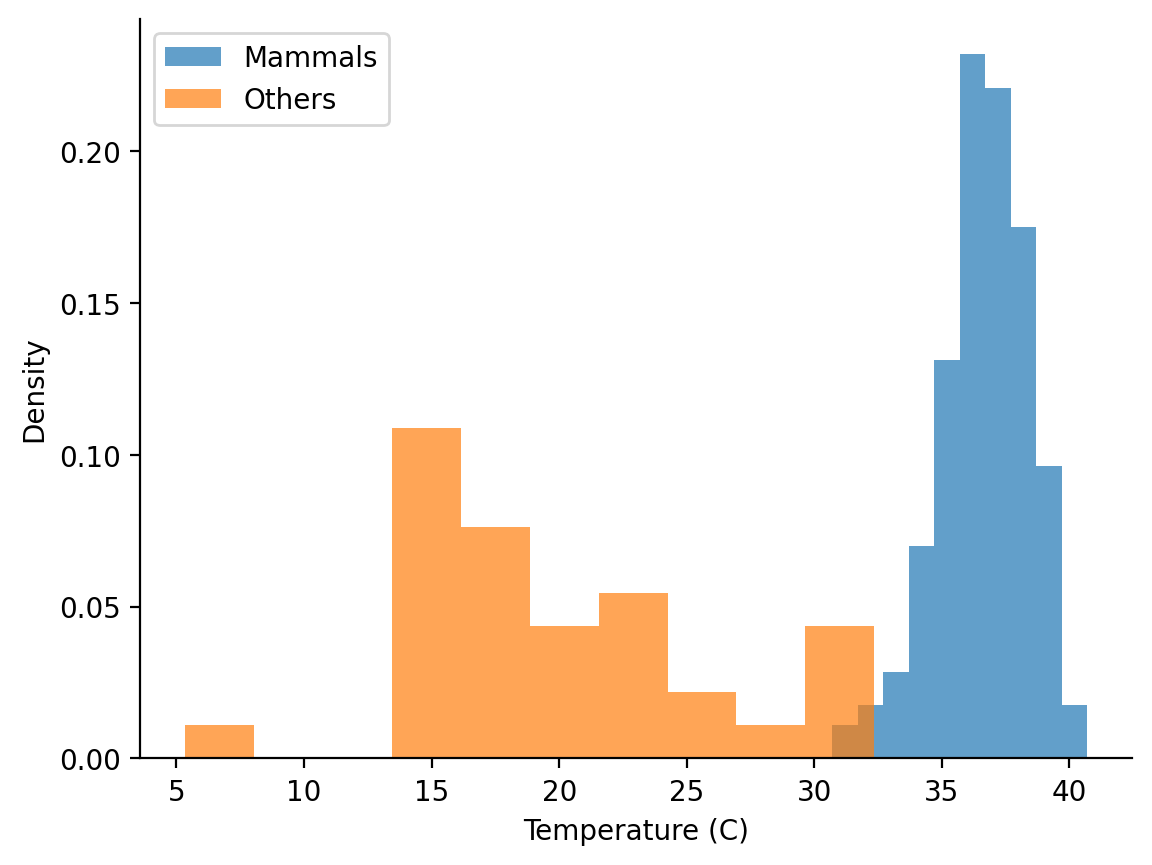

In [25]:
plt.hist(data.loc[mammals, 'Temperature (C)'], density=True, alpha=0.7, label='Mammals')
plt.hist(data.loc[~mammals, 'Temperature (C)'], density=True, alpha=0.7, label='Others')
plt.legend()
plt.xlabel('Temperature (C)')
plt.ylabel('Density')
sns.despine()

## Frequentist approach: t-test

OK. Now we want to compare these two empirical distribution: do they come from the same distribution? What is the probability that there is no difference between mammals and amphibians/reptiles, and that the difference we see in the dataset is a fluke?

The standard frequntist approach for this is [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test), which is used _"to determine if the means of two sets of data are significantly different from each other."_

This test assumes that the data are normally distributed around the mean (the histogram looks OK, I guess), but it also assumes that the variance is equal in the two distibutions, which doesn't seem to be the case.

A more robust test is [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test). 
The test statistic is defined as:
$$
t=\frac{\bar{X}_{1}-\bar{X}_{2}}{\sqrt{\frac{s_{1}^{2}}{N_{1}}+\frac{s_{2}^{2}}{N_{2}}}},
$$
where $X_i$ is dataset $i$, $\bar{X}_i$ is it's mean, $s_i$ it's standard deviation, and $N_i$ it's size.

The numerator is just the difference in means - we want to test if this is dignificantly different than zero.
The denominator scales the mean difference using an estimate of the standard errors of the means.

Welch's test assumes normality, but not equal variance.

**Compute $t$ and print it.**

In [26]:
X1 = data.loc[mammals, 'Temperature (C)'].values ###
X2 = data.loc[~mammals, 'Temperature (C)'].values ###

X1bar = X1.mean()
X2bar = X2.mean()
s1 = X1.std(ddof=1)
s2 = X2.std(ddof=1)
N1 = X1.size
N2 = X2.size

t = (X1bar - X2bar) / np.sqrt(s1 * s1 / N1 + s2 * s2 / N2)

print('t = {:.3f}'.format(t)) ###

t = 16.454


Welch showed that that $t$ is approximately t-distributed:

$$
t \sim \mathbb{t}(\nu)
$$

where the parameter $\nu$ for the distribution of $t$ is
$$
\nu \approx \frac{\left(\frac{s_{1}^{2}}{N_{1}}+\frac{s_{2}^{2}}{N_{2}}\right)^{2}}{\frac{s_{1}^{4}}{N_{1}^{2} \nu_{1}}+\frac{s_{2}^{4}}{N_{2}^{2} \nu_{2}}}
$$
where $\nu_i = N_i-1$. We won't get into how this is all constructed -- this requires some mathematical abckground.

However, we will compute the probability to draw from $\mathbb{t}(\nu)$ a value as extreme as $t$.
We will print this probability, which is commonly called the _p-value_ of the test.

This p-value tells gives us what we were looking for: the probability that the two distributions actually have the same mean, despite the disparity we see.
As you will see, the p-value is extremely low, and therefore we can reject the hypothesis (which is usually called the null hypothesis) that there is no difference between the temperature of mammals and amphibians/reptiles.

_Note:_ we use `scipy.stats.t.sf(x) * 2` (`sf(x) = 1 - cdf(x)`), which returns the probability to get a value as extreme (very large or very small) as `x`. This "very small or very large" is considered a two-sided test: we want to if either mean is much greater than the other one.

In [27]:
###
ν = (s1 * s1 / N1 + s2 * s2 / N2)**2 / (s1**4 / (N1*N1*(N1-1)) + s2**4 / (N2 * N2 * (N2-1)))

pvalue = scipy.stats.t.sf(t, ν) * 2
print('p-value: {:.2g}'.format(pvalue)) 

p-value: 1.4e-17


By the way, we could have just used `scipy.stats.ttest`. Here's how to do that:

In [28]:
###
t, pvalue = scipy.stats.ttest_ind(X1, X2, equal_var=False)
print("P-value: {:.2g} (t={:.3f})".format(pvalue, t))

P-value: 1.4e-17 (t=16.454)


## Bayesian approach: BEST

Now let's do this using Bayesian statistics, with an approach called BEST ([Bayesian Estimation Supersedes the T-test](https://psycnet.apa.org/fulltext/2012-18082-001.pdf)).

The nice thing is that once we understand Bayesian inference, we can easily understand BEST; whereas with the t-test, we need to specifically understand t-distributions, which looks very complicated.

How are we modelling the data?
Similarly to the t-test, we assume normality:

$$
X_1 \sim N(\mu_1, \sigma_1^2) $$$$
X_2 \sim N(\mu_2, \sigma_2^2)
$$

So the model parameters are $\mu_1$, $\mu_2$, $\sigma_1$, and $\sigma_2$.

**Start by infering the model parameters** using _PyMC_ (or some other Bayesian inference method if you prefer).

To have a full description of our model we need to specify the prior for $\theta$.
We provide wide priors for $\mu_i$ around the sample mean, and some exponential prior for the standard deviation terms: 

$$
\mu_i \sim N(\bar{X}, 50), $$$$
\sigma_i \sim Exp(10)
$$

here $\bar{X}$ is the mean of all the samples (including all of $X_1$ and $X_2$), and $Exp(10)$ is an exponential distribution with mean 10 (implemented with `scipy.stats.expon(scale=10)`).

In [29]:
X = np.concatenate((X1, X2)) ###
Xbar = X.mean() ###

In [30]:
import pymc as pm
import arviz as az
print("PyMC", pm.__version__, "Arviz", az.__version__)

PyMC 5.16.1 Arviz 0.18.0


In [16]:
with pm.Model() as model:
    μ1 = pm.Normal('μ1', mu=Xbar, sigma=50)
    μ2 = pm.Normal('μ2', mu=Xbar, sigma=50)
    
    σ1 = pm.Exponential('σ1', 10)
    σ2 = pm.Exponential('σ2', 10)
    
    X1_obs = pm.Normal('X1', mu=μ1, sigma=σ1, observed=X1)
    X2_obs = pm.Normal('X2', mu=μ2, sigma=σ2, observed=X2)
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ1, μ2, σ1, σ2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


In [32]:
idata.to_netcdf("idata_BEST.nc")

'idata_BEST.nc'

In [33]:
idata = az.from_netcdf("idata_BEST.nc")

**Plot a trace plot** to make sure the Markov chain has converged.

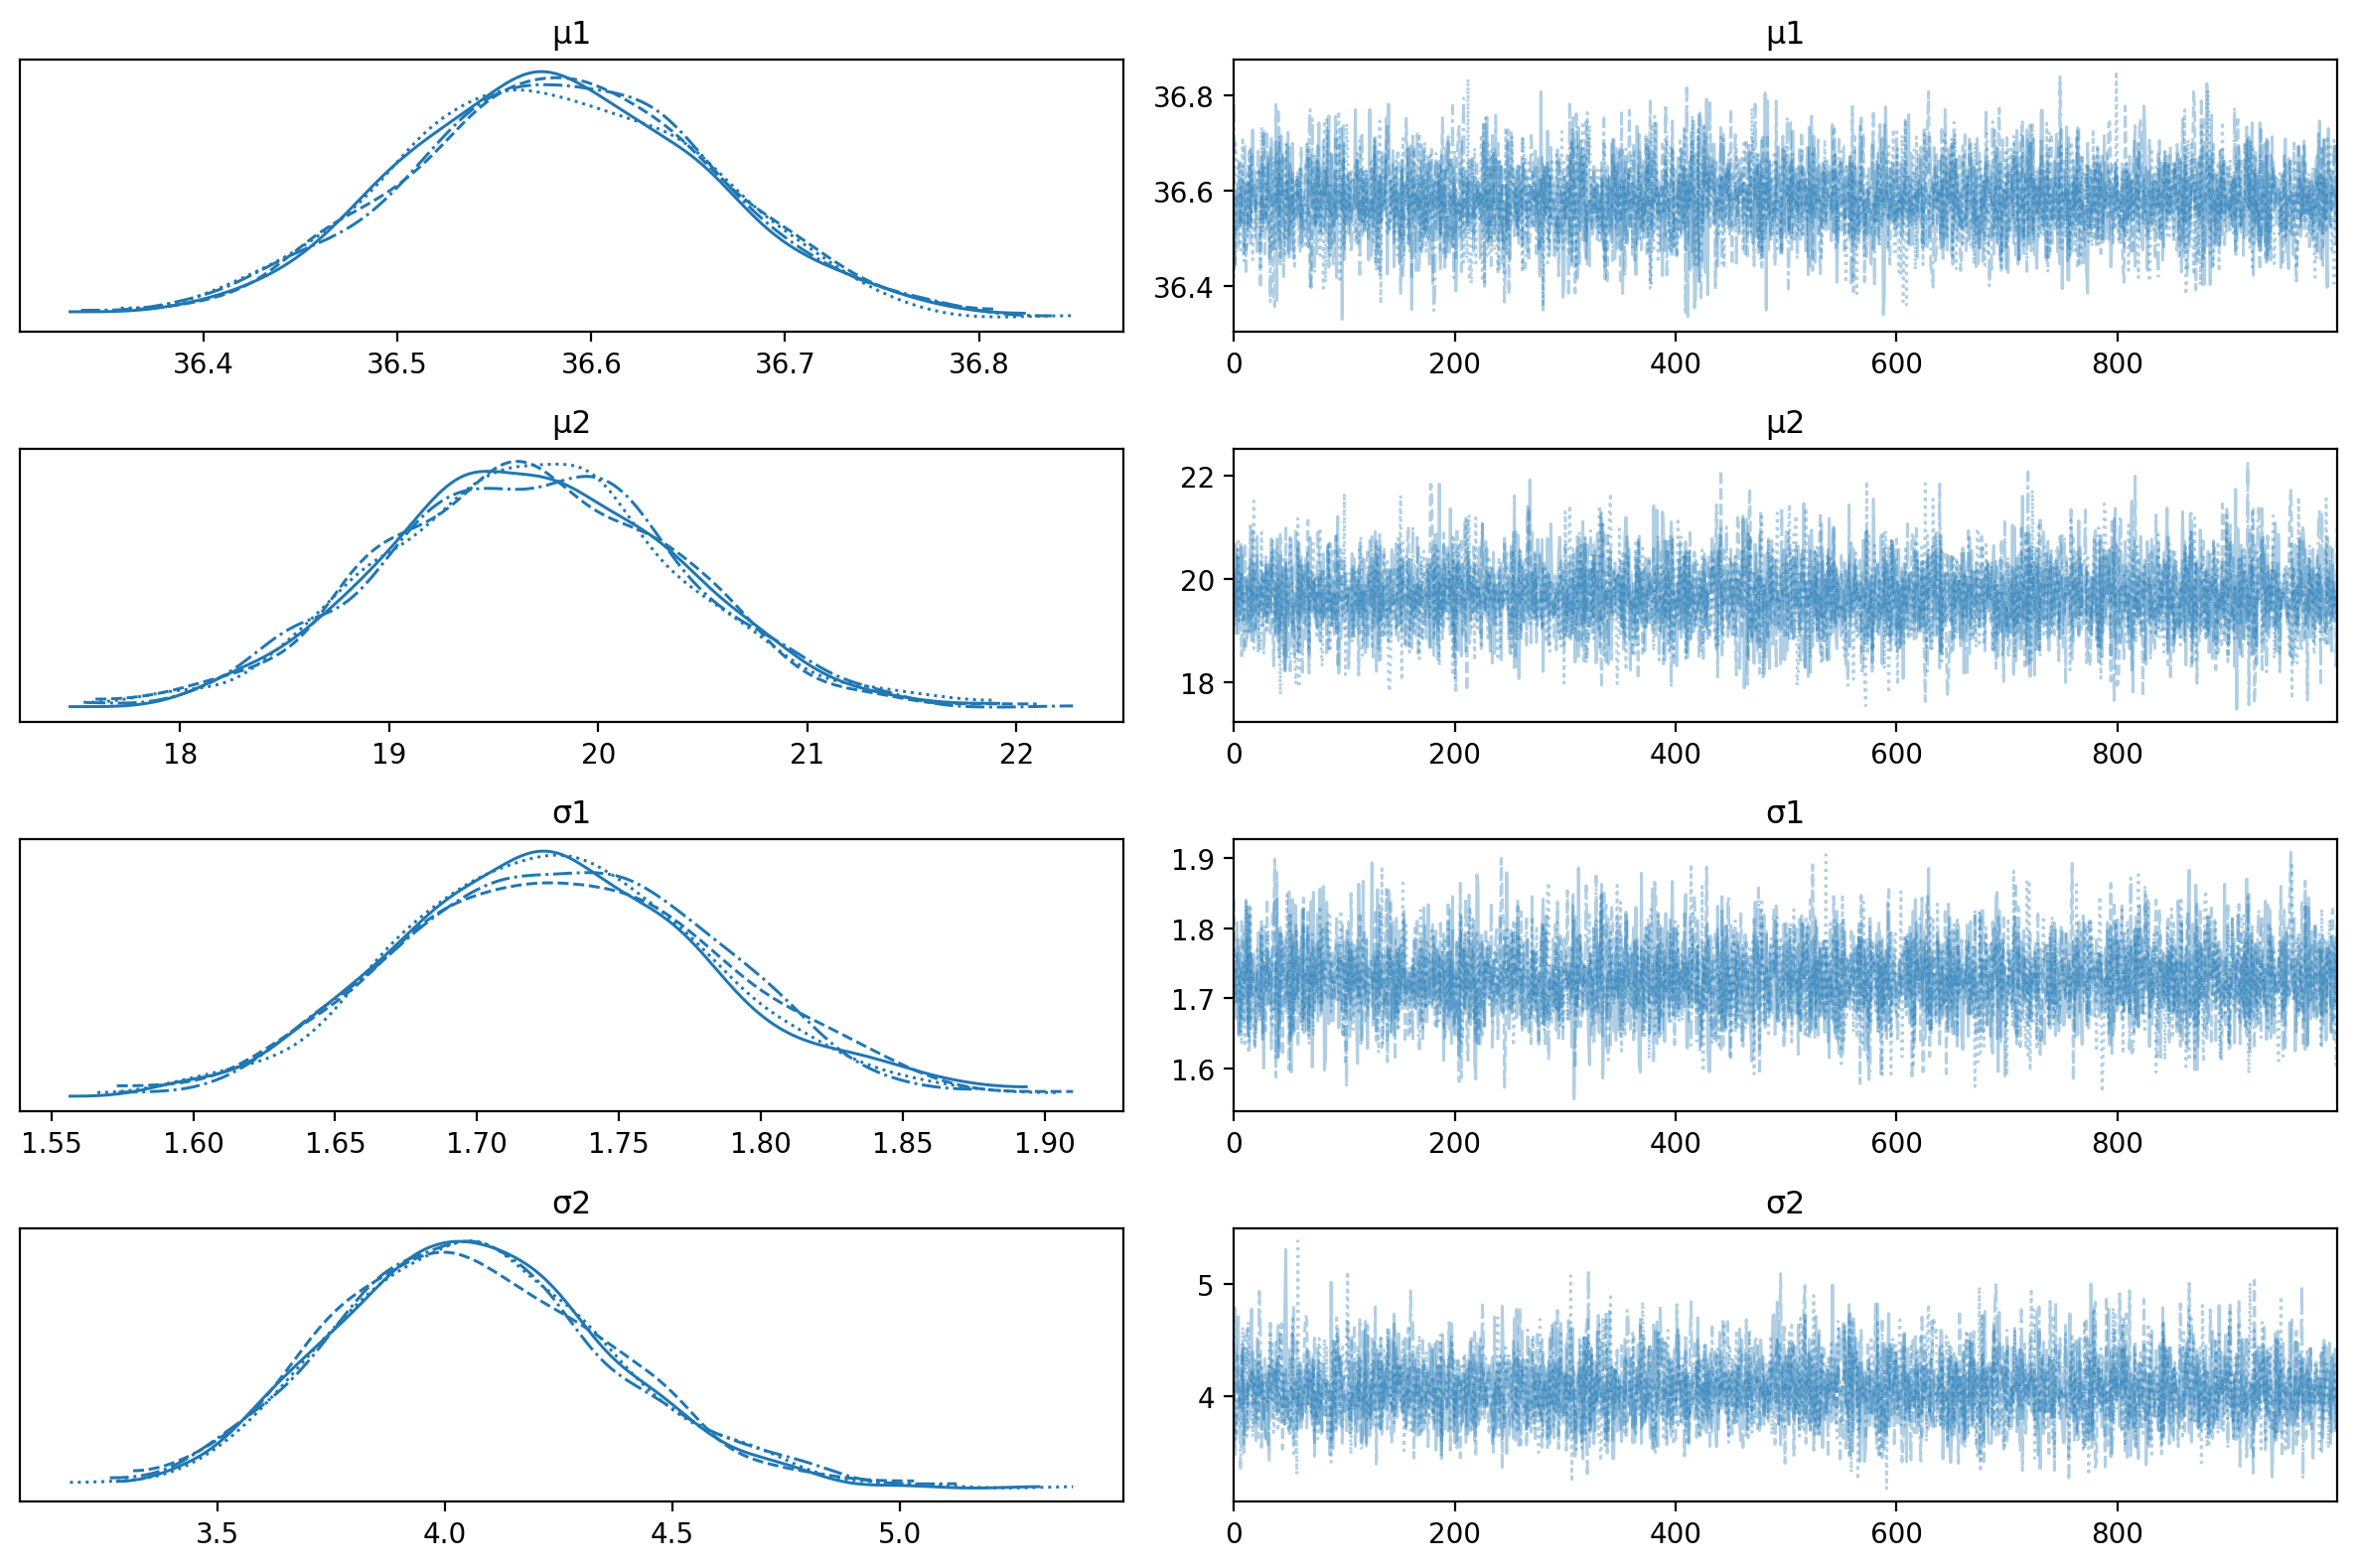

In [34]:
az.plot_trace(idata)
plt.tight_layout();

**Plot a pair plot** to examine the posterior. It should show nice gaussians, both on and off the diagonal.

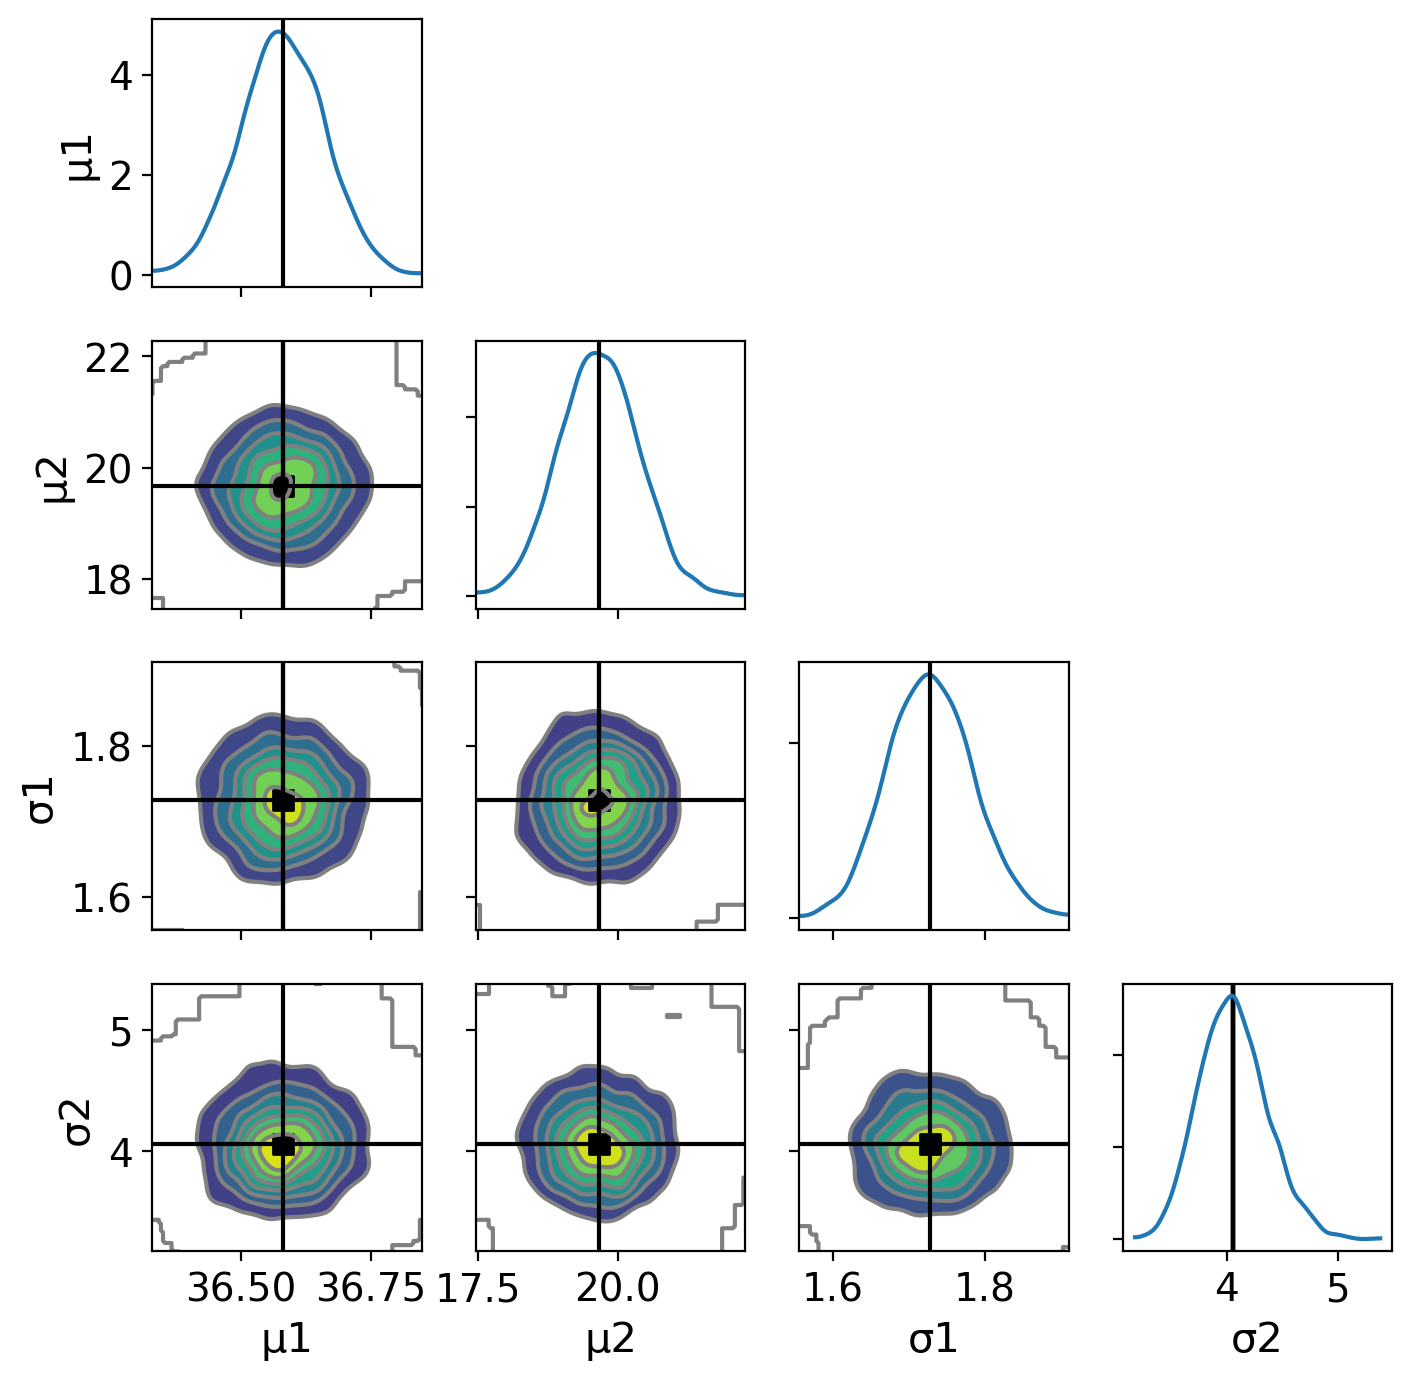

In [35]:
grid = az.plot_pair(idata, 
    kind='kde', 
    marginals=True, 
    point_estimate='mean', figsize=(8,8)
)

Finally, we can do the Bayesian estimation for the difference between the means $\mu_1$ and $\mu_2$ by computing the posterior of the difference $\Delta\mu = \mu_1 - \mu_2$:
- **extract the samples** from the inference data.
- **compute the difference** between the posterior samples of $\mu_1$ and $\mu_2$ to get posterior samples of $\Delta\mu$,
- **plot the histogram of the posterior** of $\Delta\mu$ (note how far the distribution is from zero!),
- **print the probability that $\mu_1>\mu_2$** according to the posterior of $\Delta\mu$.

P(μ1 > μ2) = 1.0


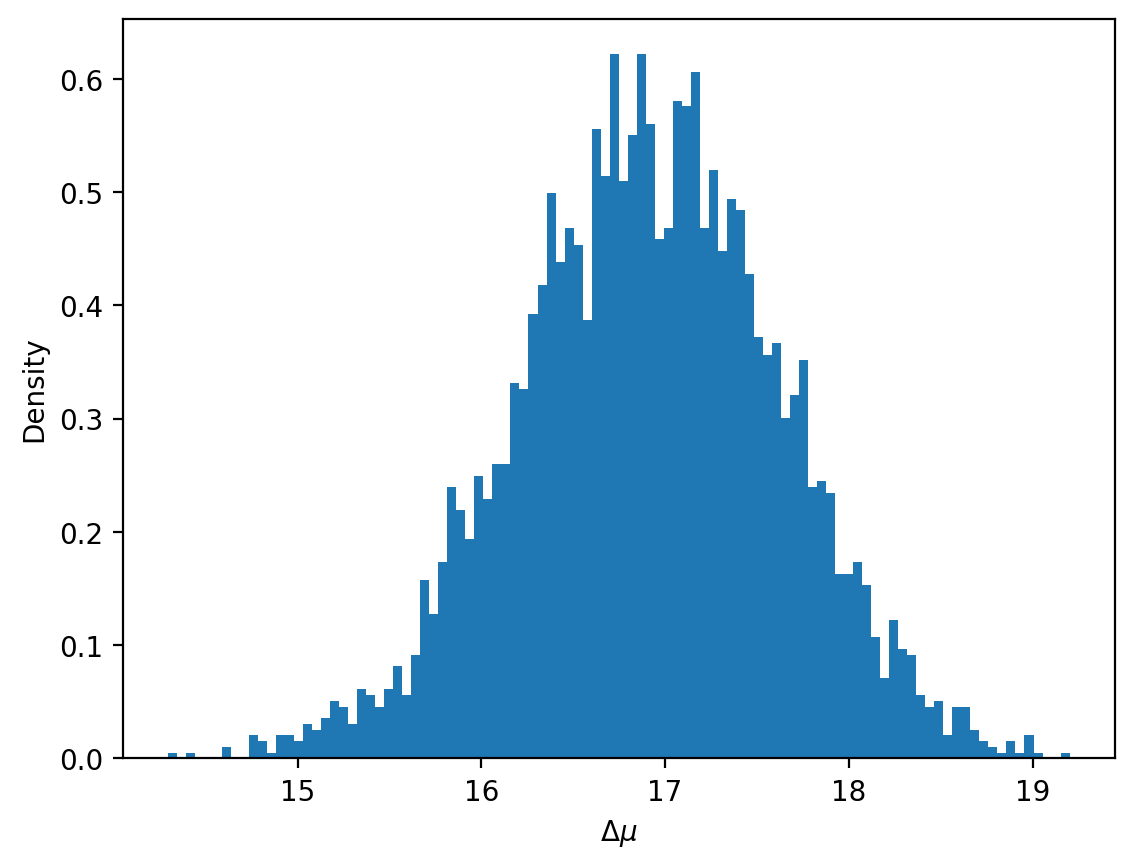

In [36]:
df = az.extract(idata, var_names=['μ1', 'μ2']).to_dataframe()
df['Δμ'] = df['μ1'] - df['μ2']

df['Δμ'].plot.hist(bins=100, density=True)
plt.xlabel(r'$\Delta\mu$')
plt.ylabel('Density')

print('P(μ1 > μ2) =', (df['Δμ'] > 0).mean())

# Ex 2: Fit Lotka-Volterra competition models to experimental data

In this section we will analyse competitions between two strains of bacteria.

Let's start by loading some data.

## Data


In [37]:
###
df = pd.read_csv('../data/flow_df_2015-11-18.csv')
df = df[['Strain','date','hour','freq_mean']]
df = df.rename(columns=dict(Strain='strain', freq_mean='frequency'))
df.head()

strain        date   hour  frequency
0  Green  11/18/2015  10:30   0.432883
1    Red  11/18/2015  10:30   0.567117
2  Green  11/18/2015  11:25   0.386035
3    Red  11/18/2015  11:25   0.613965
4  Green  11/18/2015  12:10   0.337225

The data shows results of a competitions between two bacteria strains, one marked as _Green_ and the other as _Red_.
Approximately every hour, a sample was taken from the tube in which the bacteria were competing. The sample was then processed using flow cytometry to count the number of cells with either a green or a red fluorescent protein (GFP or RFP). Then, the frequencies of the green and red cells were calculated by dividing the number of cells by the total number of cells (i.e. frequency of green = number of green / (number of green + number of red)).

The frequency of each strain was recored at each time point, but times are encoded as dates and hours.
Therefore, we create a new column called `time` that has the number of hours passed since the start of the experiment.
Then we drop the `date` and `hour` columns.

In [38]:
###
# parse date and time, see http://strftime.org
df['time'] = [
    datetime.strptime(d+'-'+h, '%m/%d/%Y-%H:%M').timestamp() 
    for d,h in zip(df['date'], df['hour']) 
]
df['time'] = df['time'] - df['time'].min() # relative time to start of experiment
df['time'] /= 60*60 # to hours 
df = df.drop(columns=['date', 'hour'])

Next, **plot the frequencies of the two strains over time**.
Make sure you use the correct colors, labels, etc.

Tip: try to use `df.groupby` to generate the plot.

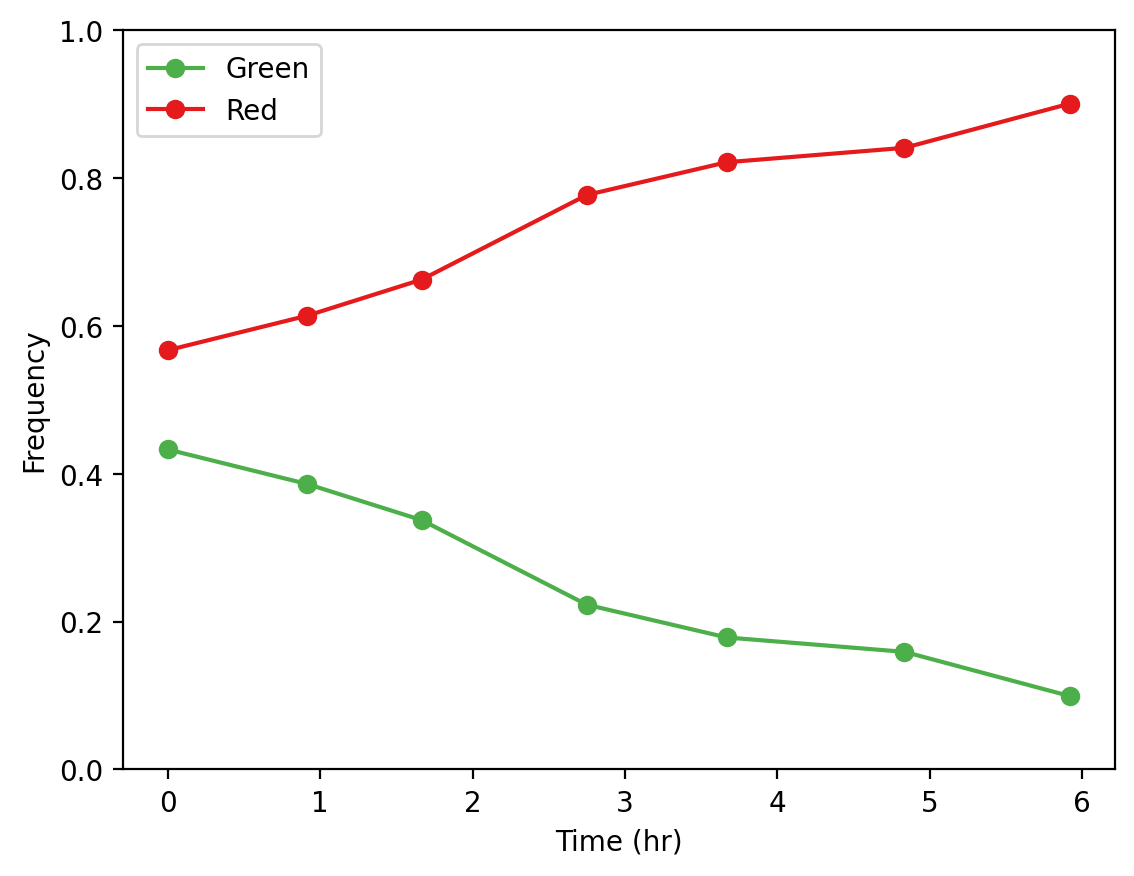

In [39]:
fig, ax = plt.subplots()
colors = dict(Red=red, Green=green)

for key, grp in df.groupby('strain'):
    grp.plot(x='time', y='frequency', ax=ax, marker='o', color=colors[key])
plt.legend(df['strain'].unique())
plt.xlabel('Time (hr)')
plt.ylabel('Frequency')
plt.ylim(0, 1);

## Model

To model competitions between two strains (or species) we will use the classical [competitive Lotka–Volterra equations](https://en.wikipedia.org/wiki/Competitive_Lotka–Volterra_equations) (not to be confused with the predator-prey Lotka-Volterra equations).

This deterministic model describes the change in the expected population sizes of the two strains, $x_1$ and $x_2$.

$$
\frac{dx_1}{dt} = r_1 x_1 \Big(1 - \bigg(\frac{x_1 + \alpha_2 x_2}{K_1}\bigg)\Big) $$$$
\frac{dx_2}{dt} = r_2 x_2 \Big(1 - \bigg(\frac{\alpha_1 x_1 + x_2}{K_2}\bigg)\Big)
$$

where $r_i$ and $K_i$ are the per-capita growth rate and maximum population size of strain $i$, and $\alpha_1$ and $\alpha_2$ are the *competition coefficients*.

Note the similarity between this model and the single-population logistic growth model; here, the growth-limiting term accounts for both strains, rather than just one.

The competition coefficients account for the relative effect individuals of strain $i$ have on growth of individuals of strain $j$ compared to other individuals of strain $i$.
Specifically, different $\alpha_i$ values can be interpreted [competition, parasitism, or even charity](https://en.wikipedia.org/wiki/Biological_interaction#Symbiosis:_long-term_interactions) (see these concepts explained by [Ernie and Bert](https://www.dropbox.com/s/gga4ggpewjus5tq/SesameSt.pptx?dl=0)).

In the following, we will 
1. fit the above model (LV6) to the data,
1. fit a nested, simpler, model (LV4) to the data, in which $\alpha_1=\alpha_2=1$; that is, strain $i$ has the same effect on strain $j$ as it does on itself.
1. select the best model out of the two.

The names LV6 and LV4 are due to the model name (Lotka-Volterra) and the number of free parameters.

## Implementation

**Write a function called `LV6_ode(t, x, ...)`** that takes the time `t`, an array `x` of populations sizes at time `t`, and the rest of the model parameters, and returns an array of the derivatives of `x` with respect to `t`; $\bigg(\frac{dx_1}{dt}, \frac{dx_2}{dt}\bigg)$.

**Write another function called `LV4_ode(t, x, ...)`** that performs the same operation, but with the competition parameters set to 1.

In [40]:
def LV6_ode(t, x, *params): ###
    r1, r2, K1, K2, α1, α2 = params
    x1, x2 = x
    return (r1 * x1 * (1 - (x1 + α2 * x2)/K1),
            r2 * x2 * (1 - (α1 * x1 + x2)/K2))

def LV4_ode(t, x, *params): ### 
    r1, r2, K1, K2 = params
    return LV6_ode(t, x, r1, r2, K1, K2, 1, 1) # α1, α2 = 1, 1

Now **write a function called `model(ode, t, xinit, ...)`** that takes an ODE function `ode` (such as `LV6_ode` or `LV4_ode`), time points `t`, initial values `xinit` for the population sizes, and any required parameters values.
The function then integrates the ODE and returns the population <u>*frequencies*</u> at the time points `t`.

In [41]:
def model(ode, t, xinit, *params): ###
    result = solve_ivp(lambda t, x: ode(t, x, *params), t_span=(0, t.max()), y0=xinit, t_eval=t)
    assert result.success
    x1, x2 = result.y
    xtotal = x1 + x2
    return x1/xtotal, x2/xtotal

LV4_model = partial(model, LV4_ode) ###
LV6_model = partial(model, LV6_ode) ###

**Run and plot** an example dynamics for both LV6 and LV4.
Try to choose parameters values ($r_i, K_i, \alpha_i$) that demonstrate the effect of competition on the dynamics (i.e. such that LV6 and LV4 produce distinct dynamics).

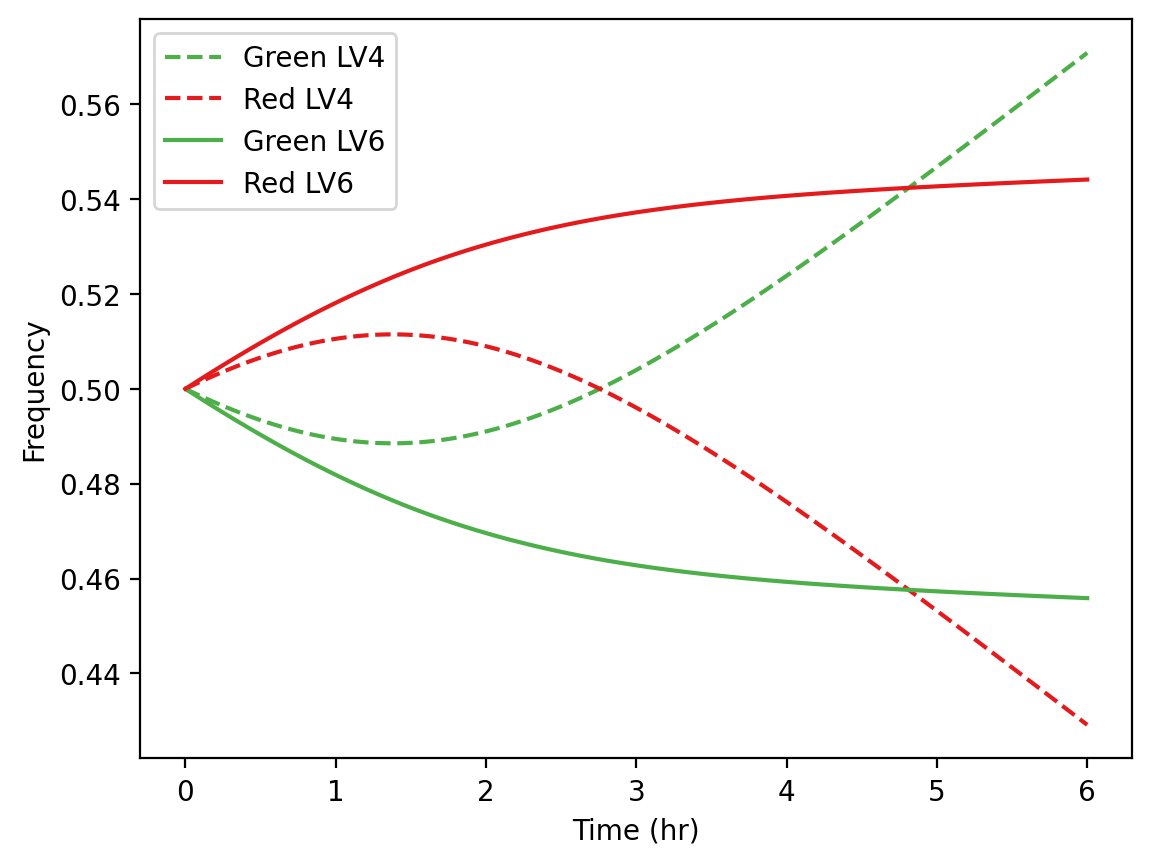

In [42]:
t = np.linspace(0, 6, 100)

x1, x2 = LV4_model(t, [0.1, 0.1], 1, 1.1, 1.1, 1)
plt.plot(t, x1, label='Green LV4', color=green, ls='--')
plt.plot(t, x2, label='Red LV4', color=red, ls='--')

x1, x2 = LV6_model(t, [0.1, 0.1], 1, 1.1, 1.1, 1, 0.9, 1.1)
plt.plot(t, x1, label='Green LV6', color=green)
plt.plot(t, x2, label='Red LV6', color=red)

plt.xlabel('Time (hr)')
plt.ylabel('Frequency')
plt.legend();

## Model fit

We assume that the real frequencies $X_i$ are normally distributed around the model expected value $x_i$ ($i=1,2$):
$$
X_i \sim N(x_i, \sigma_i^2)
$$
where $x_i$ are the solutions to the ODEs.

If we are not interested in estimating $\sigma_i$, then the negative log likelihood (NLL) reduces to the sum of squared errors:
$$
NLL = \sum_t{(X_1 - x_1)**2}
$$
Note that because $X_1+X_2=1$, it's enough to fit just one strain.

**Fit both models to the data**.

- implement the NLL as the loss function
- minimize the NLL loss function using `scipy.optimize`. 
- what should be the value of `xinit` and `t`?

After fitting the two models, **print and plot a summary** of the fitting for each model:
- print the maximum likelihood estimated parameter values,
- plot the data together with the fitted model.

Make sure the print messages and the plots are as clear and illustrative as possible.

In [43]:
X1 = df.loc[df['strain'] == 'Green', 'frequency'].values ###
X2 = df.loc[df['strain'] == 'Red', 'frequency'].values ###
xinit = df.loc[df['time'] == 0, 'frequency'].values
t = df['time'].unique()

def loss(params, model): ###
    x1, x2 = model(t, xinit, *params)
    return ((x1 - X1)**2).sum()

loss_LV4 = partial(loss, model=LV4_model) ###
loss_LV6 = partial(loss, model=LV6_model) ###

In [44]:
result_LV4 = scipy.optimize.minimize(loss_LV4, [1, 1, 1, 1])
assert result_LV4.success
print('LV4 loss: {:.2g}'.format(result_LV4.fun))
print('r={:.2f}, {:.2f}; K={:.2f}, {:.2f}'.format(*result_LV4.x))
print()
result_LV6 = scipy.optimize.minimize(loss_LV6, [1, 1, 1, 1, 1, 1])
print('LV6 loss: {:.2g}'.format(result_LV6.fun))
print('r={:.2f}, {:.2f}; K={:.2f}, {:.2f}; α={:.2f}, {:.2f}'.format(*result_LV6.x))

LV4 loss: 0.0015
r=7.43, 7.44; K=11.54, 12.09

LV6 loss: 0.00088
r=1.99, 2.02; K=7.98, 8.94; α=0.40, 0.91


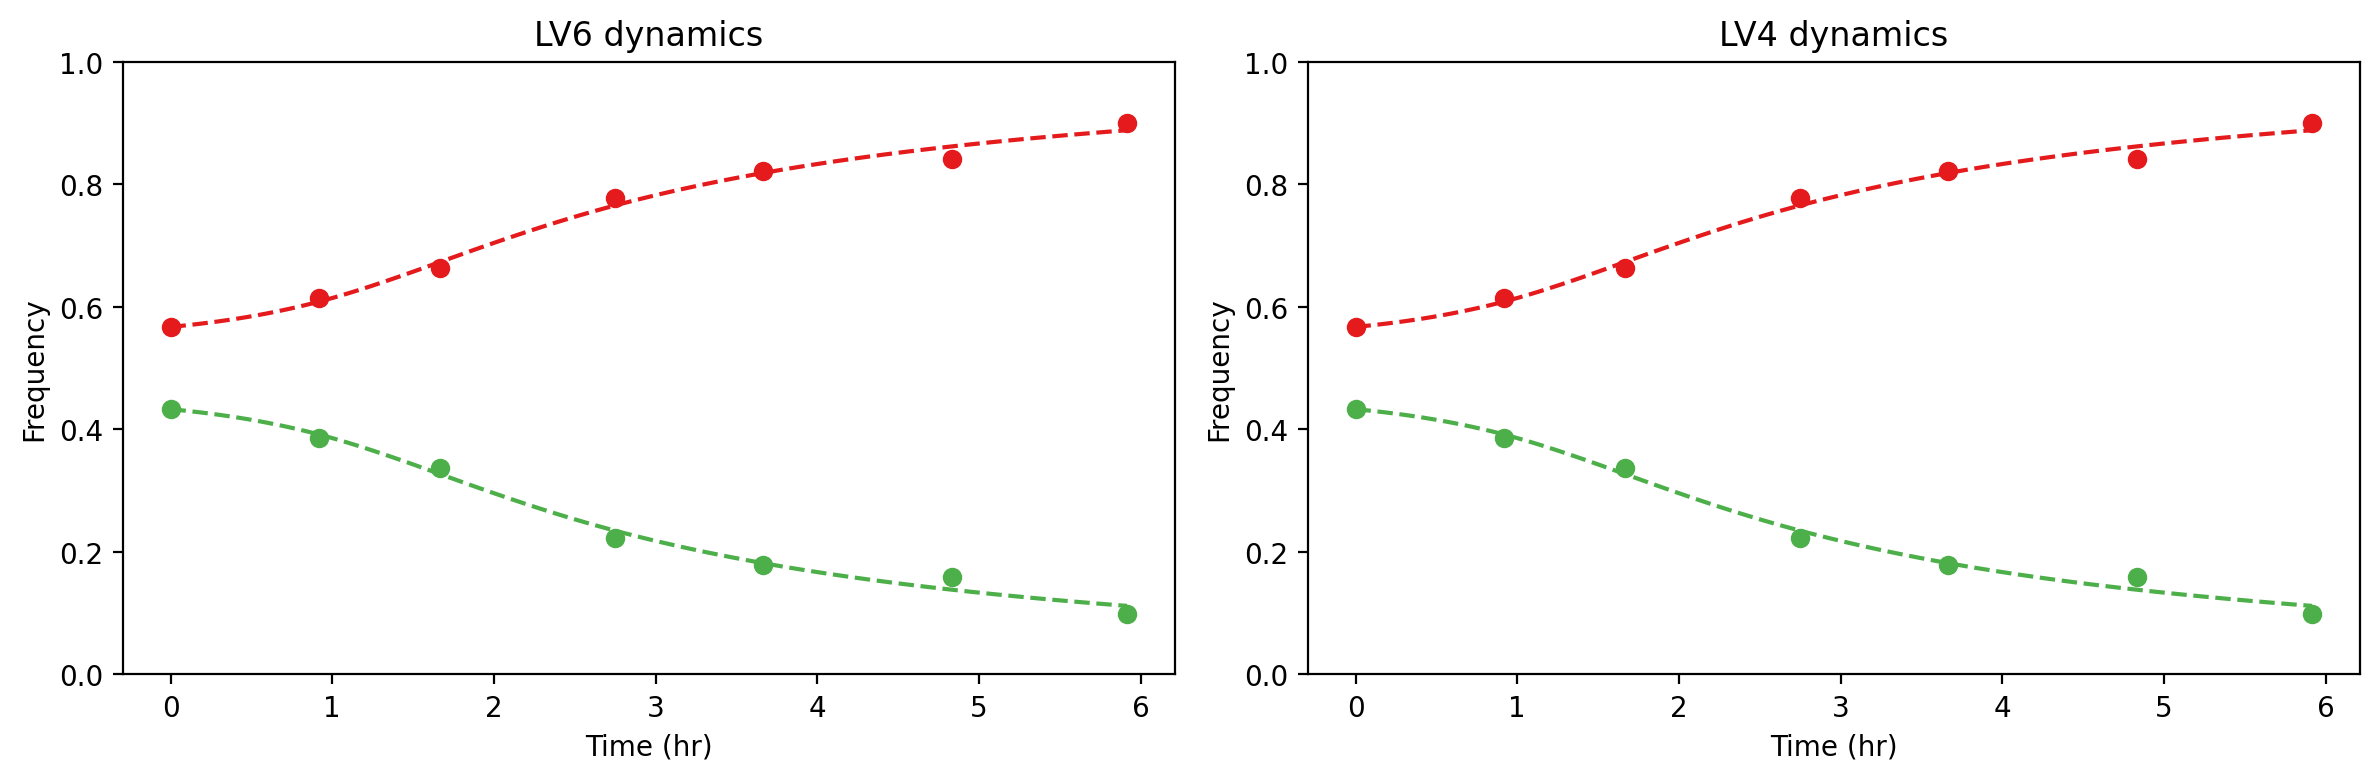

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
t_range = np.linspace(t.min(), t.max(), 100)

x1, x2 = LV6_model(t_range, xinit, *result_LV6.x)

ax = axes[0]
ax.plot(t, X1, 'o', color=green, label='Observed green')
ax.plot(t, X2, 'o', color=red, label='Observed red')
ax.plot(t_range, x1, '--', color=green, label='Predicted green')
ax.plot(t_range, x2, '--', color=red, label='Predicted red')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Frequency')
ax.set_ylim(0, 1)
ax.set_title('LV6 dynamics')

x1_, x2_ = LV4_model(t_range, xinit, *result_LV4.x)

ax = axes[1]
ax.plot(t, X1, 'o', color=green, label='Observed green')
ax.plot(t, X2, 'o', color=red, label='Observed red')
ax.plot(t_range, x1, '--', color=green, label='Predicted green')
ax.plot(t_range, x2, '--', color=red, label='Predicted red')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Frequency')
ax.set_ylim(0, 1)
ax.set_title('LV4 dynamics')

fig.tight_layout()

## Model selection

Since it may be difficult to decide which model is better based on the summaries above, **perform model selection** to select one of the models and answer the question:  _can the nested model LV4 be rejected in favor of the full model LV6?_

Print and plot any required steps to support your decision, and finish with a clear statement answering the question above.

If you are not sure how to perform model selection, I would recommend the [likelihood ratio test](https://en.wikipedia.org/wiki/F-test#Regression_problems).

In [46]:
import scipy.stats

n = t.size # number of samples
p0 = 4 # number of parameters in null model
p1 = 6 # number of parameters in alternative model
F = ((result_LV4.fun - result_LV6.fun) / (p1 - p0)) / (result_LV6.fun / (n - p1)) # F-statistic, see https://en.wikipedia.org/wiki/F-test#Regression_problems
pvalue = scipy.stats.f(p1 - p0, n - p1).sf(F) # sf = 1 - cdf
print("F-statistic: {:.2g}".format(F))
print("Likelihood-ratio test p-value = {:.2g}".format(pvalue))
print("The nested model is rejected:", pvalue < 0.05)

F-statistic: 0.34
Likelihood-ratio test p-value = 0.77
The nested model is rejected: False


**end of assignment**